In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from gender_io_nokey import get_genders
from gender_io import get_genders
from genderPredictor import genderPredictor
% matplotlib inline

### Import Name/Gender labeled data from online to use as a validation set
Create a new dataframe which combines and shuffles both male and female names from the outside data source.

In [2]:
titles = ['name', 'freq', 'cum_freq', 'rank']
fem_names = pd.read_csv("http://deron.meranda.us/data/census-dist-female-first.txt", names=titles, delim_whitespace=True)
mal_names = pd.read_csv("http://deron.meranda.us/data/census-dist-male-first.txt", names=titles, delim_whitespace=True)

In [3]:
fem_new = fem_names.sample(n=500, random_state=24)
fem_new['old_index'] = fem_new.index
fem_new['sex'] = 1
mal_new = mal_names.sample(n=500, random_state=24)
mal_new['old_index'] = mal_new.index
mal_new['sex'] = 0

In [4]:
names_all = pd.concat([fem_new, mal_new], ignore_index=True)

In [5]:
names_all.head()

,name,freq,cum_freq,rank,old_index,sex
0,ARLEAN,0.001,89.575,3828,3827,1
1,ELEONORA,0.001,89.642,3890,3889,1
2,ANGELA,0.468,21.376,29,28,1
3,MARITZA,0.016,78.186,680,679,1
4,TAMMIE,0.026,74.593,507,506,1


In [6]:
names_all = names_all.sample(frac=1, random_state=12).reset_index(drop=True)

In [8]:
names_all.head()

,name,freq,cum_freq,rank,old_index,sex
0,HOLLIS,0.009,87.170,707,706,0
1,GRAIG,0.004,89.958,1196,1195,0
2,LUCIEN,0.007,88.242,844,843,0
3,CIERRA,0.003,85.738,1751,1750,1
4,DARCEY,0.001,89.735,3979,3978,1


### Get data from Genderize.io to use for model comparison
Since genderize.io can only convert 10 names at a time, create a list of lists which contains all the names.

In [9]:
names_only = np.array(names_all['name'])
new_list = [names_only[i:i+10] for i in range(0, len(names_only), 10)]

In [10]:
genderize = pd.DataFrame(columns=['name','count','prob','sex'])
genderize

,name,count,prob,sex


In [11]:
for names in new_list:
    lst_names = get_genders(list(names))
    for grp in zip(list(names), lst_names):
        genderize = genderize.append({'name': grp[0], 'count': grp[1][2], 
                                      'prob': grp[1][1], 'sex': grp[1][0]}, ignore_index=True)

In [12]:
genderize.head(), len(genderize)

(     name  count  prob     sex
 0  HOLLIS   11.0  0.55  female
 1   GRAIG    5.0  1.00    male
 2  LUCIEN   41.0  0.98    male
 3  CIERRA   30.0  1.00  female
 4  DARCEY   31.0  0.55    male, 1000)

In [13]:
genderize['count'] = genderize['count'].astype(float)
genderize['prob'] = genderize['prob'].astype(float)

#### DO NOT USE ORIGINAL COPY OF GENDERIZE DATAFRAME

In [33]:
genderize_cp = genderize.copy()

In [16]:
genderize.to_csv('genderize_orig.csv')

### Create the alternate naive bayes model

In [17]:
run genderPredictor.py

names.pickle exists, loading data
names.pickle loaded
32031 male names loaded, 56347 female names loaded
Accuracy: 0.968941
Most Informative Features
	last_three = ENA
	last_three = INA
	last_three = CIA
	last_three = LIA
	last_three = NNA
	last_two = DO
	last_three = SIA
	last_three = TTA
	last_three = SHA
	last_three = ISA
Enter name to classify: Meena

Meena is classified as F


In [18]:
gp = genderPredictor()

In [19]:
accuracy = gp.trainAndTest()

names.pickle exists, loading data
names.pickle loaded
32031 male names loaded, 56347 female names loaded


In [20]:
feats = gp.getMostInformativeFeatures(10)

### Create a function to test model accuracy

In [21]:
def get_acc(actual, pred):
    count = 0
    for each in zip(actual, pred):
        if each[0] == each[1]:
            count += 1
    return 100 * float(count)/len(actual)

Alternate Naive Bayes Model

In [22]:
gp_preds = [gp.classify(name) for name in names_only]

In [23]:
set(gp_preds)

{'F', 'M'}

In [24]:
anb_pred = [0 if name == 'M' else 1 for name in gp_preds]

In [48]:
anb_acc = get_acc(list(names_all['sex']), anb_pred)

In [53]:
print("The Naive Bayes Model accuracy is %s%%." % anb_acc)

The Naive Bayes Model accuracy is 79.4%.


Genderize Model

In [28]:
set(genderize['sex'])

{u'None', u'female', u'male'}

In [29]:
genderize_preds = []
for name in genderize['sex']:
    if name == 'male':
        genderize_preds.append(0)
    elif name == 'female':
        genderize_preds.append(1)
    else:
        genderize_preds.append(2)

In [55]:
gen_acc = get_acc(list(names_all['sex']), genderize_preds)

In [56]:
print("The Genderize.io model accuracy is %s%%." % gen_acc)

The Genderize.io model accuracy is 88.5%.


### Where the Genderize model can improve

In [57]:
genderize_exp = genderize.copy()

In [60]:
genderize_exp['actual_sex'] = names_all['sex']

In [64]:
genderize_exp['sex'].replace('female', 1, inplace=True)
genderize_exp['sex'].replace('male', 0, inplace=True)
genderize_exp['sex'].replace('None', 2, inplace=True)

In [65]:
genderize_exp.head()

,name,count,prob,sex,actual_sex
0,HOLLIS,11.0,0.55,1,0
1,GRAIG,5.0,1.00,0,0
2,LUCIEN,41.0,0.98,0,0
3,CIERRA,30.0,1.00,1,1
4,DARCEY,31.0,0.55,0,1


In [77]:
genderize_exp['sex'].value_counts()

0    512
1    462
2     26
Name: sex, dtype: int64

About 2.6% of names are marked as 'None' using Genderize.io.

In [116]:
corr_m = float(len(genderize_exp[(genderize_exp['actual_sex'] == 0) & (genderize_exp['sex'] == 0)]))
corr_f = float(len(genderize_exp[(genderize_exp['actual_sex'] == 1) & (genderize_exp['sex'] == 1)]))
total_m = len(genderize_exp[genderize_exp['actual_sex'] == 0])
total_f = len(genderize_exp[genderize_exp['actual_sex'] == 1])
corr_m, corr_f

(460.0, 425.0)

In [98]:
100*corr_m/total_m, 100*corr_f/total_f

(92.0, 85.0)

Genderize does a better job with classification of males names than it does with female names, 92% accurate for male names and 85% accurate for female names.

In [117]:
probs_1 = [0, .56, .61, .66, .71, .76, .81, .86, .91, .96]
probs_2 = [.55, .6, .65, .7, .75, .8, .85, .9, .95, 1]
pct = []
prob_cnt = []
for val1, val2 in zip(probs_1, probs_2):
    df = genderize_exp[(genderize_exp['prob'] >= val1) & (genderize_exp['prob'] <= val2)]
    count = float(sum(df['actual_sex'] == df['sex']))
    pct.append(count/len(df))
    prob_cnt.append(len(df))

In [118]:
pct, prob_cnt

([0.175,
  0.5333333333333333,
  0.7692307692307693,
  0.7692307692307693,
  0.6,
  0.7307692307692307,
  0.8,
  0.8157894736842105,
  0.8225806451612904,
  0.9561752988047809],
 [40, 15, 13, 13, 15, 26, 25, 38, 62, 753])

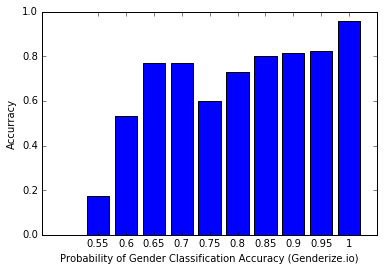

In [137]:
plt.bar(xrange(10), pct, width=0.8, bottom=None, 
        tick_label=[.55, .6, .65, .7, .75, .8, .85, .9, .95, 1],
        align='center')
plt.xlabel("Probability of Gender Classification Accuracy (Genderize.io)")
plt.ylabel("Accurracy")

Names where the classification score for Genderize.io is less than or equal to 60% confident account for less than 7% of the total sample, but are highly innacurate (two left-most bars).

### Ensemble (Combination) Gender Model

In [35]:
genderize_cp['NB_sex'] = gp_preds
genderize_cp['NB_sex'].replace('M', 'male', inplace=True)
genderize_cp['NB_sex'].replace('F', 'female', inplace=True)

In [41]:
genderize_cp.head()

,name,count,prob,sex,NB_sex
0,HOLLIS,11.0,0.55,female,male
1,GRAIG,5.0,1.00,male,male
2,LUCIEN,41.0,0.98,male,male
3,CIERRA,30.0,1.00,female,female
4,DARCEY,31.0,0.55,male,female


In [47]:
cutoffs = [.55, .6, .65, .7, .75, .8, .85, .9, .95]
for value in cutoffs:
    df = genderize_cp.copy()
    df.ix[df.prob <= value, 'sex'] = df[df['prob'] <= value]['NB_sex']
    genderize_df_preds = []
    for name in df['sex']:
        if name == 'male':
            genderize_df_preds.append(0)
        elif name == 'female':
            genderize_df_preds.append(1)
        else:
            genderize_df_preds.append(2)
    print("The cutoff is %s, the accuracy is %s." % (value, get_acc(list(names_all['sex']), genderize_df_preds)))

The cutoff is 0.55, the accuracy is 90.9.
The cutoff is 0.6, the accuracy is 91.2.
The cutoff is 0.65, the accuracy is 90.9.
The cutoff is 0.7, the accuracy is 90.7.
The cutoff is 0.75, the accuracy is 90.7.
The cutoff is 0.8, the accuracy is 90.4.
The cutoff is 0.85, the accuracy is 89.8.
The cutoff is 0.9, the accuracy is 89.5.
The cutoff is 0.95, the accuracy is 89.2.


By substituting the Naive Bayes model for classifications where the Genderize.io confidence score is less than or equal to 60%, we can achieve a nearly 3% increase in classification accuracy from the Genderize.io model alone.